# Prisoner's Dilemma Graph Visualization - Updated

This notebook visualizes the LangGraph structure for the Prisoner's Dilemma game with sequential agent execution and counter-based loop control. Each agent can make up to 5 attempts.

In [1]:
from langchain_ollama.llms import OllamaLLM
from langgraph.graph import START, END, StateGraph, MessagesState
from typing import TypedDict
from langgraph.checkpoint.memory import InMemorySaver
from prompt import good_player_prompt, bad_player_prompt
import json
from IPython.display import Image, display
from langchain_core.runnables.graph import CurveStyle, MermaidDrawMethod, NodeStyles

In [2]:
# model setup
model = "mistral:latest"
llm = OllamaLLM(model=model)

#memory setup
checkpointer = InMemorySaver()
config = { "configurable": { "thread_id": "1" } }

In [3]:
# subgraph state setup - UPDATED with separate counters
class SubgraphState(TypedDict):
    agent_1_prompt: str
    agent_1_choice: list[str]
    agent_2_prompt: str
    agent_2_choice: list[str]
    agent_1_counter: int
    agent_2_counter: int

# subgraph nodes setup - UPDATED with counter increments
def Agent1(state: SubgraphState):
    """
    Node Agent1 invokes the model with the prompt set in the state's
    "agent_1_prompt" key. The response is added to the list of
    "agent_1_choice" with the current counter value incremented by 1.
    """
    messages = llm.invoke(state["agent_1_prompt"])
    if isinstance(messages, str):
        response= json.loads(messages)
    return {"agent_1_choice": state["agent_1_choice"] + [response["agent_choice"]], "agent_1_counter": state["agent_1_counter"] + 1}

def Agent2(state: SubgraphState):
    """
    Node Agent2 invokes the model with the prompt set in the state's
    "agent_2_prompt" key. The response is added to the list of
    "agent_2_choice" with the current counter value incremented by 1.
    """
    messages = llm.invoke(state["agent_2_prompt"])
    if isinstance(messages, str):
        response= json.loads(messages)
    return {"agent_2_choice": state["agent_2_choice"] + [response["agent_choice"]], "agent_2_counter": state["agent_2_counter"] + 1}

def should_continue(state: SubgraphState) -> str:
    """This node checks if each agent has made 5 attempts.

    If either agent has fewer than 5 attempts, it returns 'loop' to continue.
    If both agents have made 5 attempts, it returns 'exit' to terminate.
    """
    if state["agent_1_counter"] < 5 or state["agent_2_counter"] < 5:
        return "loop"
    else:
        return "exit"

In [4]:
# subgraph setup - SEQUENTIAL EXECUTION WITH LOOPS
subgraph_builder = StateGraph(SubgraphState)
subgraph_builder.add_node("Agent1", Agent1)
subgraph_builder.add_node("Agent2", Agent2)

# Sequential execution starting
subgraph_builder.add_edge(START, "Agent1")
subgraph_builder.add_edge(START, "Agent2")

# Add conditional edges for both agents to allow looping
subgraph_builder.add_conditional_edges("Agent1",
                                should_continue,
                                {
                                    "loop": "Agent1",  # If 'loop', repeat the loop
                                    "exit": END,       # If 'exit', terminate the workflow
                                })
subgraph_builder.add_conditional_edges("Agent2",
                                should_continue,
                                {
                                    "loop": "Agent2",  # If 'loop', repeat the loop
                                    "exit": END,       # If 'exit', terminate the workflow
                                })
subgraph = subgraph_builder.compile(checkpointer=checkpointer)

=== SUBGRAPH VISUAL (Updated with Counters and Loop Logic) ===


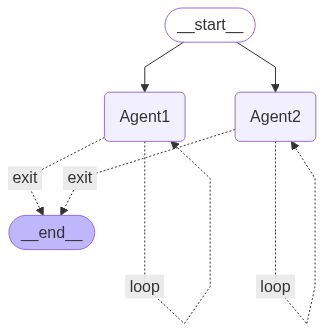

In [5]:
print("=== SUBGRAPH VISUAL (Updated with Counters and Loop Logic) ===")
display(Image(subgraph.get_graph().draw_mermaid_png()))

## Main Graph Setup

The main graph contains the parent state and transform function that initializes and invokes the subgraph.

In [6]:
# graph state setup
class ParentState(TypedDict):
    agent_1_choice_parent: list[str]
    agent_2_choice_parent: list[str]
    
# graph node setup - UPDATED to include counter initialization
def transform(state: ParentState):
    response = subgraph.invoke({"agent_1_choice": state["agent_1_choice_parent"], 
    "agent_2_choice": state["agent_2_choice_parent"], "agent_1_prompt": good_player_prompt,
    "agent_2_prompt": bad_player_prompt, "agent_1_counter": 1, "agent_2_counter": 1}, config=config)

    print("Subgraph State History:")
    print("\n")
    for event in subgraph.stream({"agent_1_choice": state["agent_1_choice_parent"], 
    "agent_2_choice": state["agent_2_choice_parent"], "agent_1_prompt": good_player_prompt,
    "agent_2_prompt": bad_player_prompt, "agent_1_counter": 1, "agent_2_counter": 1}, config=config):
        print(event)
    print("\n")
    print("Subgraph State History End")
    print("\n")
    
    return {"agent_1_choice_parent": response["agent_1_choice"], "agent_2_choice_parent": response["agent_2_choice"]}

graph_builder = StateGraph(ParentState)
graph_builder.add_node("transform", transform)
graph_builder.add_edge(START, "transform")
graph_builder.add_edge("transform", END)
graph = graph_builder.compile(checkpointer=checkpointer)

=== MAIN GRAPH VISUAL ===


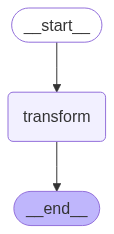

In [7]:
print("=== MAIN GRAPH VISUAL ===")
display(Image(graph.get_graph().draw_mermaid_png()))

## Game Execution

Run the complete game with the updated logic.

In [8]:
def run_game():
    for event in graph.stream({
        "agent_1_choice_parent": [],
        "agent_2_choice_parent": []
    }, subgraphs=True, config=config):
        print(event)

# Uncomment to run the game
run_game()

Subgraph State History:


{'Agent2': {'agent_2_choice': ['DEFECT'], 'agent_2_counter': 2}}
{'Agent1': {'agent_1_choice': ['COOPERATE'], 'agent_1_counter': 2}}
{'Agent1': {'agent_1_choice': ['COOPERATE', 'COOPERATE'], 'agent_1_counter': 3}}
{'Agent2': {'agent_2_choice': ['DEFECT', 'DEFECT'], 'agent_2_counter': 3}}
{'Agent2': {'agent_2_choice': ['DEFECT', 'DEFECT', 'DEFECT'], 'agent_2_counter': 4}}
{'Agent1': {'agent_1_choice': ['COOPERATE', 'COOPERATE', 'COOPERATE'], 'agent_1_counter': 4}}
{'Agent2': {'agent_2_choice': ['DEFECT', 'DEFECT', 'DEFECT', 'DEFECT'], 'agent_2_counter': 5}}
{'Agent1': {'agent_1_choice': ['COOPERATE', 'COOPERATE', 'COOPERATE', 'COOPERATE'], 'agent_1_counter': 5}}
{'Agent2': {'agent_2_choice': ['DEFECT', 'DEFECT', 'DEFECT', 'DEFECT', 'DEFECT'], 'agent_2_counter': 6}}
{'Agent1': {'agent_1_choice': ['COOPERATE', 'COOPERATE', 'COOPERATE', 'COOPERATE', 'COOPERATE'], 'agent_1_counter': 6}}


Subgraph State History End


((), {'transform': {'agent_1_choice_parent': ['C